In [ ]:
!pip -q install -U gensim

     |████████████████████████████████| 24.1 MB 1.7 MB/s 


In [ ]:
import pickle
import random
import pytz
from datetime import datetime
import numpy as np
from tqdm.auto import tqdm
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Load Embeddings

In [ ]:
with open("drive/MyDrive/LangOn/convmorph/convmorph_dataset.pkl", "rb") as fin:
  (vocabs, embs) = pickle.load(fin)

kv = KeyedVectors(200)
kv.add_vectors(vocabs, embs)

In [ ]:
class ConvmorphDataset(Dataset):
  def __init__(self, vocabs, embs):
    self.build_dataset(vocabs, embs)

  def build_dataset(self, vocabs, embs):
    vocab_map = {vocab: idx for idx, vocab in enumerate(vocabs)}
    self.data = []
    for idx in tqdm(range(len(vocabs)), desc="building dataset"):
      word = vocabs[idx]
      if len(word) < 2: continue
      if not (word[0] in vocab_map and word[1] in vocab_map):
        continue
      emb = embs[idx]
      const1_vec = embs[vocab_map[word[0]]]
      const2_vec = embs[vocab_map[word[1]]]
      const1 = word[0]
      const2 = word[1]
      self.data.append(dict(
          word=word,
          const1=const1, const2=const2,
          word_vec=emb,
          const1_vec=const1_vec, const2_vec=const2_vec
      ))
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
cm_ds = ConvmorphDataset(vocabs, embs)
len(cm_ds)

building dataset:   0%|          | 0/129538 [00:00<?, ?it/s]

120838

In [ ]:
class ConvmorphDatasetArc(Dataset):
  def __init__(self, cm_dataset, idxs):
    self.build_dataset(cm_dataset, idxs)

  def build_dataset(self, ds, idxs):
    self.data = []
    for serial, idx in enumerate(idxs):
      data_x = ds[idx]
      inputX = np.concatenate([
          data_x["const1_vec"], data_x["const2_vec"]
      ]).reshape(1, 20, 20)
      target = data_x["word_vec"]
      self.data.append(dict(
          word_id=serial,
          word=data_x["word"],
          inputX=torch.tensor(inputX, dtype=torch.float32),
          target=torch.tensor(target, dtype=torch.float32)
      ))
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]


In [ ]:
import pickle
with open("drive/MyDrive/LangOn/convmorph/split_indices_500k.pkl", "rb") as fin:
  data = pickle.load(fin)
  train_idxs = data["train_idxs"]
  test_idxs = data["test_idxs"]
N = len(cm_ds)
rng = np.random.RandomState(123)
random_split = np.arange(N)
rng.shuffle(random_split)
train_words = set(cm_ds[i]["word"] for i in train_idxs)
train_ds = ConvmorphDatasetArc(cm_ds, train_idxs)
test_ds = ConvmorphDatasetArc(cm_ds, test_idxs)
train_eval_ds = ConvmorphDatasetArc(cm_ds, train_idxs[-len(test_ds):])
print(len(train_idxs), len(test_idxs), len(train_eval_ds))

114796 6042 6042


## Model definition

In [ ]:
from dataclasses import dataclass
import torch.nn.functional as F

@dataclass
class ConvmorphArcModelOutput:
  loss: torch.tensor
  pred_vec: torch.tensor

class ConvmorphArcModel(nn.Module):
  def __init__(self, dropout=0.1):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, 3)
    self.norm1 = nn.LayerNorm([128, 18, 18])
    self.conv2 = nn.Conv2d(128, 128, 3)
    self.norm2 = nn.LayerNorm([128, 16, 16])    
    self.conv3 = nn.Conv2d(128, 128, 3)
    self.norm3 = nn.LayerNorm([128, 14, 14])    
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.norm4 = nn.LayerNorm([128, 12, 12])
    self.conv5 = nn.Conv2d(128, 128, 3)
    self.norm5 = nn.LayerNorm([128, 10, 10])
    
    self.pool1 = nn.MaxPool2d(2)
    self.fn1 = nn.Linear(128*5*5, 3000)
    self.drop1 = nn.Dropout(p=dropout)
    self.fn4 = nn.Linear(3000, 200)
  
  def forward(self, inputX, target=None, **kwargs):
    
    z = F.relu(self.norm1(self.conv1(inputX)), inplace=True)
    z = F.relu(self.norm2(self.conv2(z)), inplace=True)
    z = F.relu(self.norm3(self.conv3(z)), inplace=True)
    z = F.relu(self.norm4(self.conv4(z)), inplace=True)    
    z = F.relu(self.norm5(self.conv5(z)), inplace=True)    
    z = self.pool1(z).view(-1, 128*5*5)
    o = self.drop1(torch.tanh(self.fn1(z)))    
    o = self.fn4(o)
    pred_vec = o

    if target is not None:
      loss_fct = nn.MSELoss()
      loss = loss_fct(pred_vec, target)
      return ConvmorphArcModelOutput(loss, pred_vec)
    else:      
      return ConvmorphArcModelOutput(float('nan'), pred_vec)
    

In [84]:
from torch.utils.data import TensorDataset, DataLoader

def compute_projections(model, words, ref_kv, device="cuda"):  
  model.eval()
  with torch.no_grad():
    neigh_vecs = np.vstack([ref_kv[word_x] for word_x in words])
    inputX = neigh_vecs.reshape(-1, 20, 20)
    inputX = np.expand_dims(inputX, axis=1)
    inputX = torch.tensor(inputX)
    pred_vecs = []
    for batch_x in DataLoader(TensorDataset(inputX), 
                            shuffle=False, 
                            batch_size=128):
      inputX_batch = batch_x[0].to(device)
      pred_batch = model(inputX=inputX_batch).pred_vec.cpu().numpy().squeeze()
      pred_vecs.append(pred_batch)
    
    pred_vecs = np.vstack(pred_vecs)
      
  return pred_vecs

def compute_neighbor_similarities(model, target, neighbors, ref_kv, device="cuda"):
  target_vec = compute_projections(model, [target], ref_kv, device)[0]
  neighbor_vecs = compute_projections(model, neighbors, ref_kv, device)
  sim_vecs = ref_kv.cosine_similarities(target_vec, neighbor_vecs)
  return sim_vecs

In [88]:
compute_neighbor_similarities(model, "聯絡", ["溝通", "網絡"], kv1)
# compute_neighbor_similarities(linproj, "聯絡", ["溝通", "網絡"], kv1)

array([0.79064643, 0.96796614], dtype=float32)

In [ ]:
def make_predictions(model, word, kv, topk=5, metainfo=True, show_original=False):  
  model.eval()
  with torch.no_grad():
    const1_vec = kv[word[0]]
    const2_vec = kv[word[1]]
    inputX = np.concatenate([const1_vec, const2_vec]).reshape(20, 20)
    inputX = np.expand_dims(inputX, axis=(0, 1))
    batch_x = {"inputX": torch.tensor(inputX, dtype=torch.float32).to("cuda")}
    pred_vec = model(**batch_x).pred_vec.cpu().numpy().squeeze()
    distances = kv.distances(pred_vec)
    arg_idx = np.argsort(distances)
    word_idx = kv.key_to_index.get(word, -1)
    candidates = [(kv.index_to_key[idx], 1-distances[idx]) for idx in arg_idx[:topk]]

    if word_idx >= 0:
      pred_rank = np.where(arg_idx==word_idx)[0][0]
    else:
      pred_rank = -1
  
  if metainfo:
    print("In dataset/training: {}/{}".format(
        word in kv.key_to_index, word in train_words))
    print("Predicted rank: ", pred_rank)

  if show_original and word_idx >= 0:
    print("-- In ori. embedding --")
    print(*kv.most_similar(word, topn=topk), sep="\n")
    print("-----------------------")
      
  return candidates
    

In [ ]:
def compute_accuracy(model, data_loader, test_embs, topk=5, return_corrects=False):
  n_correct = 0
  n_items = 0
  model.eval()
  corrects = []
  for batch_x in tqdm(data_loader):
      with torch.no_grad():
        batch_x = {k: v.to("cuda") for k, v in batch_x.items() if k!="word"}
        word_ids = batch_x["word_id"].cpu().numpy()
        pred_vec = model(**batch_x).pred_vec         
        norm_vec = pred_vec / torch.norm(pred_vec, dim=1).unsqueeze(1)           
        preds = torch.argsort(-torch.matmul(norm_vec, test_embs.transpose(1, 0)), dim=1).cpu().numpy()[:, :topk]                
        in_topk = np.any(word_ids[:, np.newaxis]==preds, axis=1)        
        n_correct += np.array(in_topk, dtype=np.int32).sum()
        corrects.extend(word_ids[in_topk].tolist())
        n_items += len(preds)         
    
  if return_corrects:
    out = (n_correct/n_items, corrects)
  else:
    out = n_correct/n_items
  return out

In [ ]:
## Load Model
model = ConvmorphArcModel().to("cuda")
model_path = "drive/MyDrive/LangOn/convmorph/0403-1959-arc/model.pth"
states = torch.load(model_path)
model.load_state_dict(states())  # I made a mistake when saving state_dict. The saved state is a bound function.
_ = model.eval()

In [228]:
print("{:.2f}M parameters".format(sum([x.numel() for x in model.parameters()])/1e6))

11.06M parameters


## Linear Projection

In [81]:
trainA = np.vstack([
      np.concatenate(
          [cm_ds[idx]["const1_vec"], cm_ds[idx]["const2_vec"]]
      ) for idx in train_idxs])
trainB = np.vstack([cm_ds[idx]["word_vec"] for idx in train_idxs])
AtA_inv = np.linalg.inv(np.dot(trainA.transpose(), trainA))
trainX = np.dot(np.dot(AtA_inv, trainA.transpose()), trainB)
trainA.shape, trainB.shape, trainX.shape

((114796, 400), (114796, 200), (400, 200))

$$
AX=B \\
X = (A^\top A)^{-1}A^\top B
$$

In [82]:
@dataclass
class LinearProjectionOutput:  
  pred_vec: torch.tensor

class LinearProjection(nn.Module):
  def __init__(self, proj, device):
    super().__init__()
    self.proj = torch.tensor(proj, dtype=torch.float32).to(device)
  
  def forward(self, inputX, **kwargs):
    inputX = inputX.view(-1, 400)
    return LinearProjectionOutput(torch.matmul(inputX, self.proj))
linproj = LinearProjection(trainX, "cuda")

## Build kv1 and kv2

In [ ]:
vocab1 = []; mask = []; embs1 = []
for word, emb_x in tqdm(zip(vocabs, embs)):
  if len(word) < 2:
    mask.append(False) 
    continue
  if word[0] not in vocabs or word[1] not in vocabs:
    mask.append(False)
    continue
  vocab1.append(word)
  mask.append(True)
  embs1.append(np.concatenate([kv[word[0]], kv[word[1]]]))
embs1 = np.vstack(embs1)
embs2 = embs[mask, :]

0it [00:00, ?it/s]

In [ ]:
kv1 = KeyedVectors(400)
kv1.add_vectors(vocab1, embs1)

In [ ]:
kv2 = KeyedVectors(200)
vocab2 = [x for x, m in zip(vocabs, mask) if m]
kv2.add_vectors(vocab2, embs2)

In [ ]:
kv2.vectors.shape, kv1.vectors.shape

((120838, 200), (120838, 400))

In [148]:

def compute_spearmans(target, topn=[10,20,30,50,80,100,150,200,300,400]):
  sim_rows = []
  for k in topn:
    ref_neighs = kv2.most_similar(target, topn=k)
    ref_words, kv2_sims = list(zip(*ref_neighs))
    kv1_sims = 1-kv1.distances(target, ref_words)
    conv_sims = compute_neighbor_similarities(model, target, ref_words, kv1)
    linear_sims = compute_neighbor_similarities(linproj, target, ref_words, kv1)
    sim_df = pd.DataFrame(dict(
              word=ref_words, ref=kv2_sims, 
              kv1=kv1_sims, conv=conv_sims, lin=linear_sims))
    sim_corr = sim_df.corr(method="spearman").iloc[0,:]
    sim_corr["k"] = k
    sim_rows.append(sim_corr)
  corr_df = pd.DataFrame(sim_rows).reset_index(drop=True).drop("ref", axis=1)
  return corr_df

In [165]:
vocab1[2100:2120]

['说过',
 '动物',
 '一度',
 '一套',
 '我市',
 '夏天',
 '声明',
 '多年',
 '回忆',
 '56',
 '故意',
 '他有',
 '碰到',
 '只见',
 '37',
 '之时',
 '古代',
 '各个',
 '命令',
 '进口']

In [172]:
len(vocab1)

120838

In [219]:
word_corr_list = []
for i in tqdm(range(0, len(vocab1), 1000)):
  word_x = vocab1[i]
  word_corr = compute_spearmans(word_x, [10,20,30,40,50,80,100,150,200])
  word_corr["word"] = word_x
  word_corr_list.append(word_corr)
word_corr = pd.concat(word_corr_list)

  0%|          | 0/121 [00:00<?, ?it/s]

In [220]:
def ub(x):
  return np.mean(x) + np.std(x)/np.sqrt(len(x))
def lb(x):
  return np.mean(x) - np.std(x)/np.sqrt(len(x))
corr_stat = word_corr.groupby("k").agg([np.mean, lb, ub])

In [221]:
corr_stat.head()

kv1                          conv                           lin  \
          mean        lb        ub      mean        lb        ub      mean   
k                                                                            
10.0  0.185675  0.152519  0.218830  0.226647  0.194784  0.258509  0.213023   
20.0  0.175144  0.149497  0.200792  0.271534  0.247646  0.295423  0.225502   
30.0  0.202140  0.181189  0.223091  0.276125  0.255017  0.297233  0.228800   
40.0  0.214423  0.194471  0.234376  0.291982  0.270895  0.313069  0.247507   
50.0  0.193177  0.174642  0.211711  0.279981  0.260583  0.299379  0.235556   

                          
            lb        ub  
k                         
10.0  0.184568  0.241477  
20.0  0.200382  0.250621  
30.0  0.207064  0.250535  
40.0  0.225901  0.269114  
50.0  0.215299  0.255812

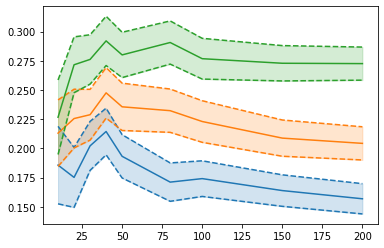

In [222]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
var_name = ["kv1", "lin", "conv"]
for i in range(3):  
  lb = corr_stat.loc(axis=1)[var_name[i], "lb"]
  ub = corr_stat.loc(axis=1)[var_name[i], "ub"]
  plt.plot(corr_stat.loc(axis=1)[var_name[i], "mean"], color=colors[i])
  plt.plot(lb, linestyle="dashed", color=colors[i])
  plt.plot(ub, linestyle="dashed", color=colors[i])
  plt.fill_between(corr_stat.index.values, lb, ub, color=colors[i]+"33")

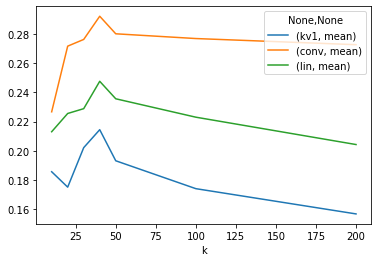

In [187]:

plt.plot()

('古筝', 0.7353562712669373)
('钢琴', 0.7333606481552124)
('二胡', 0.7082200646400452)
('吉他', 0.7025534510612488)
('口琴', 0.6872202754020691)
('琴行', 0.6866143941879272)
('弹唱', 0.6854289174079895)
('琴', 0.684245228767395)
('提琴', 0.6778519749641418)
('弹琴', 0.6737927198410034)


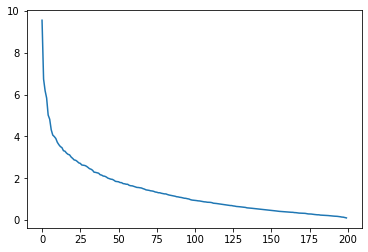

In [ ]:
use_random = False
if not use_random:
  const1_vec = kv["琴"]
  const2_vec = kv["做"]
else:
  const1_vec = np.random.randn(200)
  const2_vec = np.random.randn(200)
  const1_vec /= np.linalg.norm(const1_vec)
  const2_vec /= np.linalg.norm(const2_vec)

inputX = np.concatenate([const1_vec, const2_vec]).reshape(20, 20)
inputX = np.expand_dims(inputX, axis=(0, 1))
batch_x = {"inputX": torch.tensor(inputX, dtype=torch.float32).to("cuda")}
with torch.no_grad():
  pred_vec = model(**batch_x).pred_vec.cpu().numpy().squeeze()
  distances = kv.distances(pred_vec)
  arg_idx = np.argsort(distances)
print(*[(kv.index_to_key[idx], 1-distances[idx]) for idx in arg_idx[:10]], sep='\n')
J = torch.autograd.functional.jacobian(lambda x: model(inputX=x).pred_vec, batch_x["inputX"])
J = J.squeeze().reshape(200,400).cpu().numpy()
plt.plot(np.linalg.svd(J)[1])

In [ ]:
make_predictions(model, "流輪", kv, show_original=True, topk=10)

In dataset/training: False/False
Predicted rank:  -1


[('衝擊', 0.7969532608985901),
 ('破壞', 0.7939232587814331),
 ('場地', 0.7935033440589905),
 ('電車', 0.7924220561981201),
 ('謀殺', 0.7919973731040955),
 ('賽車', 0.7895629405975342),
 ('殺人', 0.7857447266578674),
 ('綁架', 0.7854118943214417),
 ('變形', 0.7842212915420532),
 ('襲擊', 0.782499372959137)]

In [ ]:
make_predictions(linproj, "流輪", kv, show_original=True, topk=10)

In dataset/training: False/False
Predicted rank:  -1


[('輪', 0.8258993029594421),
 ('攻擊', 0.7881219387054443),
 ('驅動', 0.7828055620193481),
 ('襲擊', 0.7790021896362305),
 ('戰鬥', 0.7779484987258911),
 ('衝擊', 0.7769442200660706),
 ('變形', 0.776444673538208),
 ('騎士', 0.7743310928344727),
 ('循環', 0.7736592888832092),
 ('對戰', 0.7727164030075073)]

In [ ]:
make_predictions(model, "台語", kv, show_original=True, topk=10)

In dataset/training: False/False
Predicted rank:  -1


[('英語', 0.8256559371948242),
 ('教學', 0.8218063712120056),
 ('日語', 0.8217338919639587),
 ('漢字', 0.8159689903259277),
 ('現代', 0.8116838932037354),
 ('書籍', 0.8104772567749023),
 ('翻譯', 0.8090395331382751),
 ('專業', 0.8084644675254822),
 ('音樂', 0.8074579834938049),
 ('電台', 0.8059045672416687)]

In [ ]:
make_predictions(model, "天人", kv)

In dataset/training: True/True
Predicted rank:  0


[('天人', 0.8436627388000488),
 ('天神', 0.8383459448814392),
 ('天魔', 0.8379562497138977),
 ('妖魔', 0.834840714931488),
 ('通天', 0.8250735402107239)]

In [ ]:
const1_vec = kv["流"]
const2_vec = kv["動"]
const1_vec = const1_vec + np.ones(200)*0.5
# const2_vec = np.random.randn(200)
const1_vec /= np.linalg.norm(const1_vec)
# const2_vec /= np.linalg.norm(const2_vec)
inputX = np.concatenate([const1_vec, const2_vec]).reshape(20, 20)
inputX = np.expand_dims(inputX, axis=(0, 1))
batch_x = {"inputX": torch.tensor(inputX, dtype=torch.float32).to("cuda")}
with torch.no_grad():
  pred_vec = linproj(**batch_x).pred_vec.cpu().numpy().squeeze()
  distances = kv.distances(pred_vec)
  arg_idx = np.argsort(distances)
print(*[(kv.index_to_key[idx], 1-distances[idx]) for idx in arg_idx[:10]], sep='\n')
J = torch.autograd.functional.jacobian(lambda x: linproj(inputX=x).pred_vec, batch_x["inputX"])
J = J.squeeze().reshape(200,400).cpu().numpy()
J[:3, :3]

('穩定', 0.7725157141685486)
('開放', 0.7708554863929749)
('動', 0.7674612998962402)
('實現', 0.7644058465957642)
('狀態', 0.7598549127578735)
('市場', 0.7551034092903137)
('活動', 0.7518622279167175)
('改變', 0.7514178156852722)
('運作', 0.7511286735534668)
('目標', 0.7504458427429199)


array([[ 0.30634737, -0.00846043,  0.00314991],
       [ 0.00782454,  0.30937126, -0.00729562],
       [ 0.01356407,  0.02619402,  0.30032685]], dtype=float32)

In [ ]:
U, sigma, Vt = np.linalg.svd(trainX)

In [ ]:
U.shape, Vt.shape

((400, 400), (200, 200))

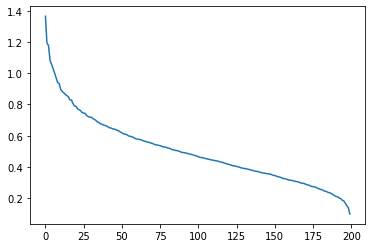

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sigma)


In [79]:
eval_embs = torch.tensor(np.vstack([x["target"] for x in test_ds]), dtype=torch.float32).to("cuda")
train_eval_embs = torch.tensor(np.vstack([x["target"] for x in train_eval_ds]), dtype=torch.float32).to("cuda")

In [ ]:
compute_accuracy(model, DataLoader(test_ds, batch_size=128, shuffle=False), eval_embs, topk=1)

  0%|          | 0/48 [00:00<?, ?it/s]

0.45564382654750085

In [80]:

compute_accuracy(linproj, DataLoader(test_ds, batch_size=128, shuffle=False), eval_embs, topk=1)

NameError: ignored

In [ ]:
compute_accuracy(linproj, DataLoader(train_eval_ds, batch_size=128, shuffle=False), train_eval_embs, topk=1)

  0%|          | 0/48 [00:00<?, ?it/s]

0.40052962595167163

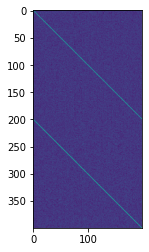

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainX)

In [ ]:
ks = [1,5,10,50]
topk_accs = [
  compute_accuracy(model, DataLoader(test_ds, batch_size=128, shuffle=False), eval_embs, topk=k)
  for k in ks
]
print(*["Top {:>2d}: {:.4f}".format(a, b) for a, b, in zip(ks, topk_accs)], sep="\n")

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Top  1: 0.4556
Top  5: 0.6311
Top 10: 0.6908
Top 50: 0.8050


In [ ]:
ks = [1,5,10,50]
topk_accs = [
  compute_accuracy(linproj, DataLoader(test_ds, batch_size=128, shuffle=False), eval_embs, topk=k)
  for k in ks
]
print(*["Top {:>2d}: {:.4f}".format(a, b) for a, b, in zip(ks, topk_accs)], sep="\n")

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Top  1: 0.3883
Top  5: 0.5723
Top 10: 0.6402
Top 50: 0.7721


In [ ]:
ks = [1,5,10,50]
topk_accs = [
  compute_accuracy(model, DataLoader(train_eval_ds, batch_size=128, shuffle=False), train_eval_embs, topk=k)
  for k in ks
]
print(*["Top {:>2d}: {:.4f}".format(a, b) for a, b, in zip(ks, topk_accs)], sep="\n")

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Top  1: 0.7761
Top  5: 0.9038
Top 10: 0.9330
Top 50: 0.9810


In [ ]:
ks = [1,5,10,50]
topk_accs = [
  compute_accuracy(linproj, DataLoader(train_eval_ds, batch_size=128, shuffle=False), train_eval_embs, topk=k)
  for k in ks
]
print(*["Top {:>2d}: {:.4f}".format(a, b) for a, b, in zip(ks, topk_accs)], sep="\n")

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Top  1: 0.4005
Top  5: 0.5846
Top 10: 0.6552
Top 50: 0.7886


In [ ]:

def compute_random_projection_baseline(N, nsample=10):
  rand_accs = []
  errors = []
  for _ in tqdm(range(nsample)):
    randA = np.random.randn(N,400)
    randB = np.random.randn(N,200)
    normrA = randA / np.linalg.norm(randA, axis=1)[:, np.newaxis]
    normrB = randB / np.linalg.norm(randB, axis=1)[:, np.newaxis]
    AtA_inv = np.linalg.inv(np.dot(normrA.transpose(), normrA))
    randX = np.dot(np.dot(AtA_inv, normrA.transpose()), normrB)
    predB = np.dot(normrA, randX)
    error_x = np.linalg.norm(predB - normrB, axis=1).mean()
    norm_predB = predB / np.linalg.norm(predB, axis=1)[:, np.newaxis]    
    preds = np.argsort(-np.dot(norm_predB, randB.transpose()), axis=1)[:, :1]
    in_topk = np.any(np.arange(predB.shape[0])[:, np.newaxis]==preds, axis=1)  
    rand_acc = np.array(in_topk, dtype=np.int32).sum() / predB.shape[0]
    rand_accs.append(rand_acc)
    errors.append(error_x)
  return rand_accs, errors
print_stat = lambda x: print(np.mean(x), np.quantile(x, [.10,.25,.50,.75,.90]))

In [ ]:
accs_400, error_400 = compute_random_projection_baseline(400)
print_stat(accs_400)
print_stat(error_400)

  0%|          | 0/10 [00:00<?, ?it/s]

1.0 [1. 1. 1. 1. 1.]
1.0111185323617783e-10 [1.32276686e-12 3.24054344e-12 2.07352679e-11 3.83924192e-11
 1.33079278e-10]


In [ ]:
accs_3k, error_3k = compute_random_projection_baseline(3000)
print_stat(accs_3k)
print_stat(error_3k)

  0%|          | 0/10 [00:00<?, ?it/s]

0.9438333333333333 [0.93893333 0.94158333 0.944      0.94625    0.94723333]
0.9306198199497171 [0.93023805 0.93038951 0.93063018 0.93084912 0.93097513]


In [ ]:
accs_6k, error_6k = compute_random_projection_baseline(6000)
print_stat(accs_6k)
print_stat(error_6k)

  0%|          | 0/10 [00:00<?, ?it/s]

0.44898333333333335 [0.44378333 0.44658333 0.4495     0.45175    0.45393333]
0.9660128958569061 [0.96595516 0.96597384 0.96598762 0.96604204 0.96610948]


In [ ]:
accs_9k, error_9k = compute_random_projection_baseline(9000)
print_stat(accs_9k)
print_stat(error_9k)

  0%|          | 0/10 [00:00<?, ?it/s]

0.18806666666666666 [0.18358889 0.18513889 0.188      0.19041667 0.19207778]
0.9774376209450205 [0.97734084 0.97739049 0.97742108 0.97748227 0.97755842]
